- Determining how accurate LLMs are at navigating a KG similar to the ones of a website
- Determining what inputs are necessary for that KG

Testing langchain’s ability to have agents as tools.

In [1]:
from langchain import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import StructuredTool

from KG_tools import *

#### Method 1

Building a classifier using LLMChain with well-designed prompt.

Close loop:
node_list(tool) -> classifier -> the_chosen_element_node -> web environment(already in KG) -> new_node_list(tool)
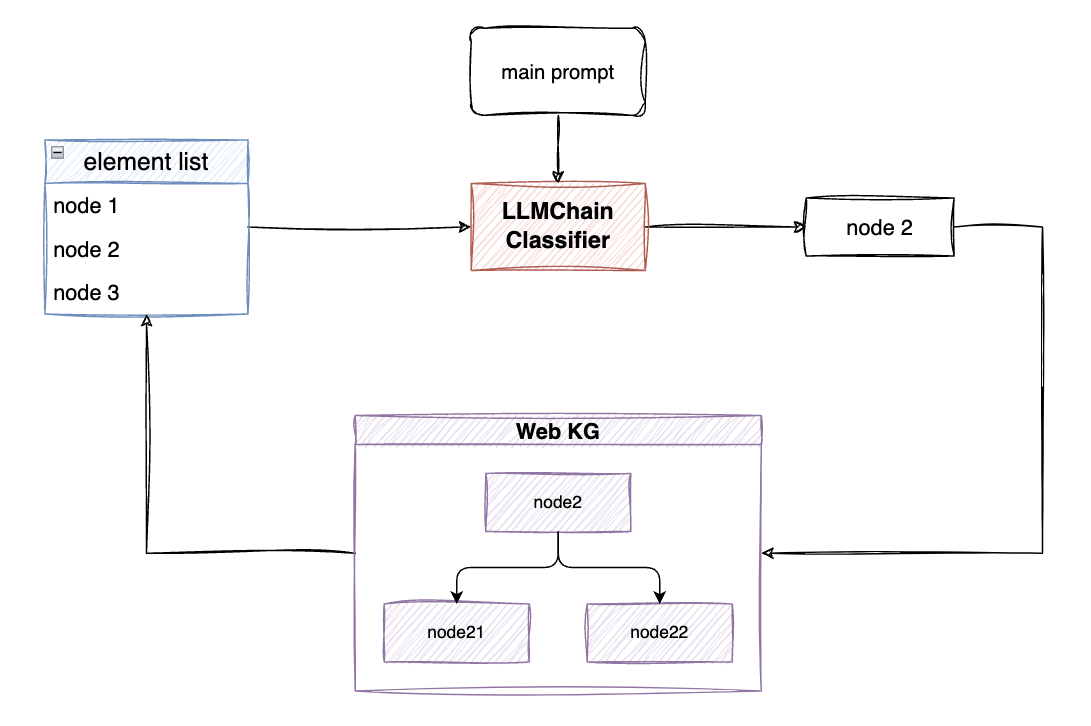

First, lets implement a next element node list search function. Given current node (action), it will output the child element node list (available next actions) in the KG (Excel table).

We can also call that tool list or whatever. But for this method we don't use them as Langchain agent tools, but only one LLM as a classifier.

In [2]:
import pandas as pd

def next_action_list(current_node, filepath="data/KG.xlsx"):
    child_node_list = []
    df = pd.read_excel(filepath)

    if current_node in df['node'].tolist():
        row = df.loc[df['node'] == current_node]
        if str(row['next_node'].tolist()[0]) != 'nan':
            child_node_list = row['next_node'].tolist()[0].split(', ')
            print("NEXT NODE LIST IS", child_node_list)
    else:
        print("NO CURRENT NODE")
    
    return child_node_list

Let's test this.

In [3]:
node_list = next_action_list("alice_getbubblez_com")

NEXT NODE LIST IS ['reply_to', 'disable', 'daily_campaign_limit']


Then, we should implement a LLM Chain classifier with MAIN_PROMPT template. We will add the node name and description to MAIN_PROMPT.

The MAIN_PROMPT design and all the node description (tool description) is the key!

In [4]:
MAIN_PROMPT = """You are a web interaction AI and you have all interactable elements of the current web page. Each element has a name and a description.
Given USER GOAL, suppose you have reached a certain stage of execution. You need to choose the element from ELEMENTS that are most likely to achieve the USER GOAL.
If you think the USER GOAL is already done at current webpage, then you choose nothing and return <EOS> directly.

The USER GOAL is:
{user_goal}

The current webpage ELEMENTS:
{tools}

You should only output selected element name or <EOS>.
Your Output: """

The classifier will initialize the LLMChain and use take_action in for loop. It will output a new element node every time and run driver.click theoretically.

Here we only run function in KG_tools.py with print function.

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate, LLMChain

class classifier:
    def __init__(self, user_goal, 
                       model_name="gpt-4", 
                       temperature=0,
                       filepath="data/KG.xlsx"
                ):

        self.temperature = temperature
        self.model_name = model_name
        self.user_goal = user_goal

        self.df = pd.read_excel(filepath)
        self.chatllm = ChatOpenAI(model_name=self.model_name, temperature=self.temperature)
        self.prompt = PromptTemplate(input_variables=["user_goal", "tools"], template=MAIN_PROMPT)
        self.chain = LLMChain(llm=self.chatllm, prompt=self.prompt, verbose=True)

    def take_action(self, action_list):
        tools_prompt = ""

        for i, action in enumerate(action_list):
            row = self.df.loc[self.df['node'] == action]

            name = action
            description = row['description'].tolist()[0]
            tools_prompt += (f"ELEMENT {i} name: " + name + f"\nELEMENT {i} description:" + description + "\n")

        next_action = self.chain.run(user_goal=self.user_goal, tools=tools_prompt)
        _ = input(f"WAITING FOR EXECUTING NEXT NODE ACTION {next_action}")
        print(f"SUCCESSFULLY EXECUTING {next_action}")

        if next_action != "<EOS>": # execute the corresponding action
            exec(f"{next_action}()")

        return next_action

Now we can build a loop like in reinforcement learning.

`take_action` is policy sampling and `next_action_list` is state transition.

In [6]:
import yaml

with open("config/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

os.environ["OPENAI_API_KEY"] = config['OPENAI_API_KEY']
TEMPERATURE = config['TEMPERATURE']
MODEL_NAME = config['MODEL_NAME']

If you want to test this method with your input, run this block. If you want to test the dataset, add your data in `data/dataset.xlsx` and run the next cell then.

In [7]:
# initialization 
agent = classifier(user_goal=input("YOUR GOAL: ")) # set the reply to email of adrianna@creatorfuel.co as aaa@bbb.com
initial_node = ["adrianna_creatorfuel_co", "aegon_tryhapley_com", "aishwarya_tryhapley_com", "alexandra_tryhapley_com", 
                 "alexis_creatorfuel_co", "ali_alchemic_ca", "alice_getbubblez_com", "alisha_creatorfuel_co"]
node = agent.take_action(initial_node)

# loop
while True:
    node_list = next_action_list(node) # return new node (state transition)
    if not len(node_list):
        print("ARRIVED END STATE")
        break

    node = agent.take_action(node_list) # choose node to click or type (taking actions)
    if node == "<EOS>":
        print("FINISH GOAL")
        break



> Entering new LLMChain chain...
Prompt after formatting:
You are a web interaction AI and you have all interactable elements of the current web page. Each element has a name and a description.
Given USER GOAL, suppose you have reached a certain stage of execution. You need to choose the element from ELEMENTS that are most likely to achieve the USER GOAL.
If you think the USER GOAL is already done at current webpage, then you choose nothing and return <EOS> directly.

The USER GOAL is:
set the reply to email of adrianna@creatorfuel.co as aaa@bbb.com

The current webpage ELEMENTS:
ELEMENT 0 name: adrianna_creatorfuel_co
ELEMENT 0 description:Clickable element. Represents the email address adrianna@creatorfuel.co, located in the first row of the table.
ELEMENT 1 name: aegon_tryhapley_com
ELEMENT 1 description:Clickable element. Represents the email address located in the first row of the table.
ELEMENT 2 name: aishwarya_tryhapley_com
ELEMENT 2 description:Clickable element representing

Run the who dataset in a for loop here.

In [9]:
import pandas as pd

df = pd.read_excel('data/dataset.xlsx')

for index, row in df.iterrows():

    # initialization 
    agent = classifier(user_goal=row['user_query'])
    initial_node = ["adrianna_creatorfuel_co", "aegon_tryhapley_com", "aishwarya_tryhapley_com", "alexandra_tryhapley_com", 
                    "alexis_creatorfuel_co", "ali_alchemic_ca", "alice_getbubblez_com", "alisha_creatorfuel_co"] # TODO
    node = agent.take_action(initial_node)

    # loop
    while True:
        node_list = next_action_list(node) # return new node (state transition)
        if not len(node_list):
            print("ARRIVED END STATE")
            break

        node = agent.take_action(node_list) # choose node to click or type (taking actions)
        if node == "<EOS>":
            print("FINISH GOAL")
            break



> Entering new LLMChain chain...
Prompt after formatting:
You are a web interaction AI and you have all interactable elements of the current web page. Each element has a name and a description.
Given USER GOAL, suppose you have reached a certain stage of execution. You need to choose the element from ELEMENTS that are most likely to achieve the USER GOAL.
If you think the USER GOAL is already done at current webpage, then you choose nothing and return <EOS> directly.

The USER GOAL is:
set the reply to email of adrianna@creatorfuel.co as aaa@bbb.com

The current webpage ELEMENTS:
ELEMENT 0 name: adrianna_creatorfuel_co
ELEMENT 0 description:Clickable element. Represents the email address adrianna@creatorfuel.co, located in the first row of the table.
ELEMENT 1 name: aegon_tryhapley_com
ELEMENT 1 description:Clickable element. Represents the email address located in the first row of the table.
ELEMENT 2 name: aishwarya_tryhapley_com
ELEMENT 2 description:Clickable element representing

#### Method 2 (Using Langchain Agent)
Using langchain agent or AgentExecutor. This method needs real tool functions.

At the beginning, the agent accepts a user goal and starts reasoning and selecting a tool, which is an element in the graph, and after selecting a tool, it executes a tool_function, which is designed to start a new agent in this function, i.e. In other words, agent, tool and element are symmetric, and the number of agents is linearly related to the number of elements.
Then, this new agent selects a new tool again and continues. With this analysis, we can find that the langchain code we built is actually a tree structure, a multinomial tree to be exact. This approach has the potential to be very overhead intensive, but also potentially more accurate, we'll see.
When an agent level tool does not exist, it means that there is no more interactive element in the state at this time, and only an end tool is provided for the agent to finish directly.

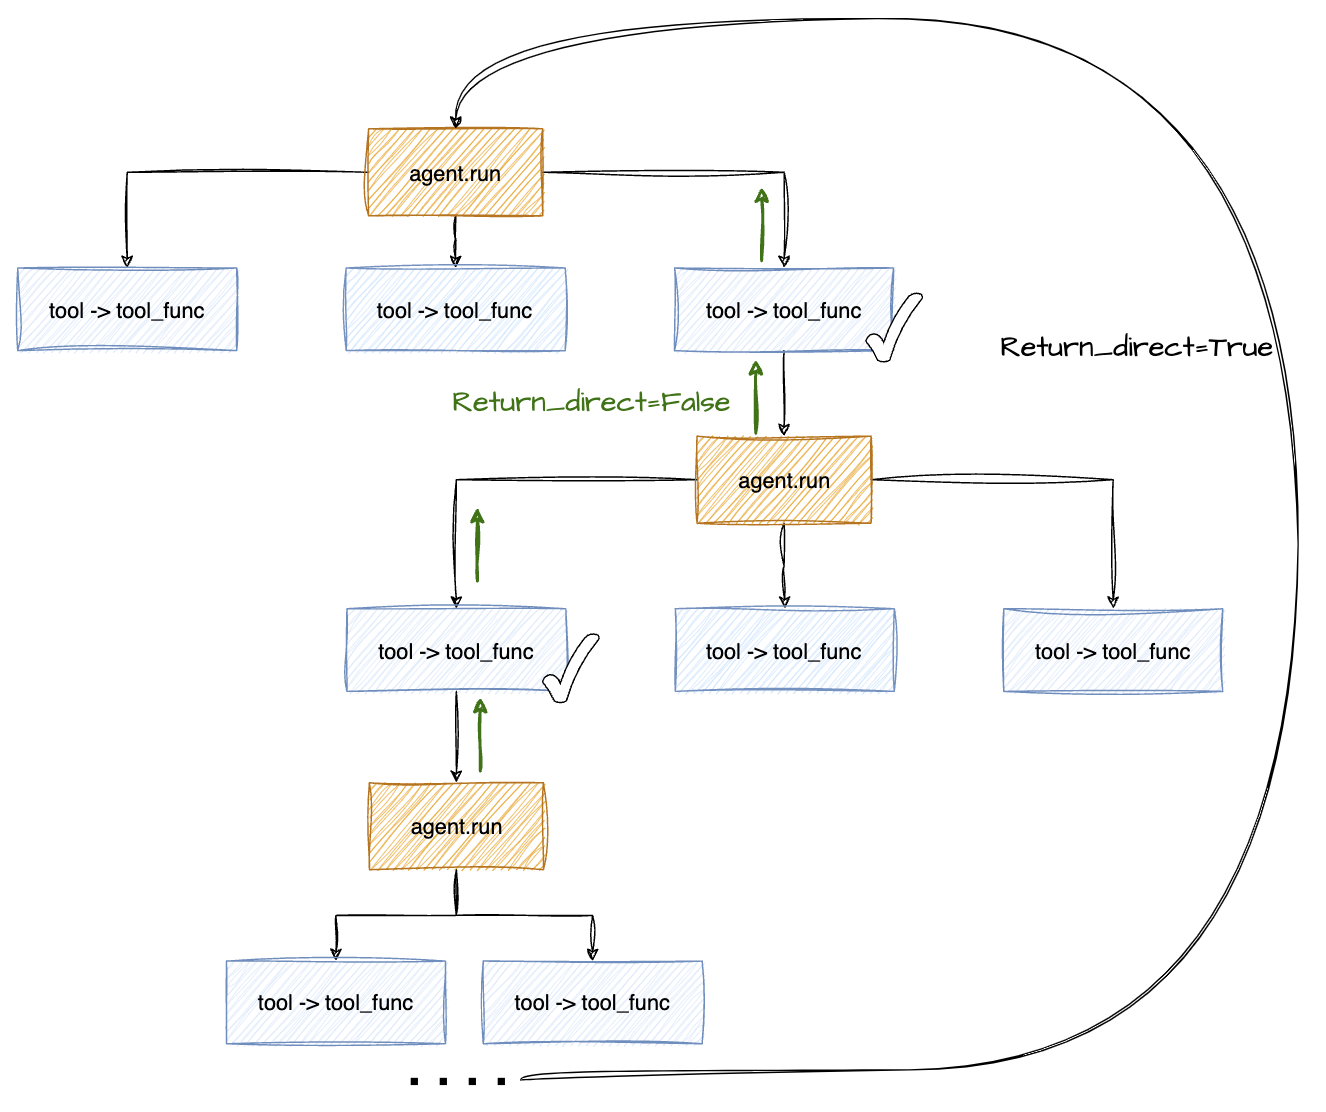

Let's test whether the langchain agent can be designed in this way. This is just a demo.

In [23]:
from langchain.tools import tool
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.llms import OpenAI

llm = OpenAI(temperature=0)

@tool('finish', return_direct=True) # Tier 3
def finish(query: str) -> str:
    """Finish. Input should be nothing."""
    print("FINISH TOOL RUNNING.")
    return 'You are at State 3. Finish.'

@tool('tool_1', return_direct=True) # Tier 2
def tool_1(query: str) -> str:
    """Input should be nothing."""
    print("TOOL_1 TOOL RUNNING.")
    tools_1 = [finish]
    agent_1 = initialize_agent(tools_1, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)
    agent_1.run("You are at state 1. Use tool 'finish' now.")
    return f"Choose tool 1 and run agent_1"

@tool('tool_2', return_direct=True) # Tier 2
def tool_2(query: str) -> str:
    """Input should be nothing."""
    print("TOOL_2 TOOL RUNNING.")
    tools_2 = [finish]
    agent_2 = initialize_agent(tools_2, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)
    agent_2.run("You are at state 2. Use tool 'finish' now.")
    return f"Choose tool 2 and run agent_2"

tools = [tool_1, tool_2] # Tier 1
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)
agent.run("tool_1 and tool_2 are two buttons you can click. Now use tool_1 directly.")



> Entering new AgentExecutor chain...
 I need to use tool_1
Action: tool_1
Action Input: NoneTOOL_1 TOOL RUNNING.


> Entering new AgentExecutor chain...
 I need to use the 'finish' tool to move to the next state.
Action: finish
Action Input: FINISH TOOL RUNNING.

Observation: You are at State 3. Finish.


> Finished chain.

Observation: Choose tool 1 and run agent_1


> Finished chain.


'Choose tool 1 and run agent_1'

Perfect. The result is good. I set return_direct attribute to True and this is important. You can try with return_direct=False and it will generate without stopping at time.

That is, for each leaf node of the tree, once you choose to return, you return directly to the root node. For our task, it means that when the agent reaches some termination state, it automatically returns to the very first page (e.g., the home page), which makes sense. And by definition, this state is almost non-existent, because there will always be buttons on the page that can be interacted with.

Now we can build the real testing code. We will still use that state function in method 1. We will name tool and agent by 'node'. Please see this part in `experimental/navigating_KG_agent.ipynb`.